In [12]:
from tensorflow.keras import optimizers
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow import keras
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, BatchNormalization
from tensorflow.keras import optimizers
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

import tools
import cv2
import numpy as np
import pickle
import random
import glob
import datetime

In [2]:
# [256, 256, 128, 32 ] --> input activation_unit_list
def get_model(activation_units_list, add_normalization):
    model = Sequential()
    
    # Say not to train first layer (ResNet) model as it is already trained
    model.add(ResNet50(include_top = False, pooling = 'avg', weights = "imagenet"))
    model.layers[0].trainable = False
    
    for activation_unit in activation_units_list:
        model.add(Dense(activation_unit, activation="relu"))
        if add_normalization:
            model.add(BatchNormalization())
    
    model.add(Dense(4, activation="relu"))
    model.compile(optimizer="adam", loss="mse", metrics=["mse", "accuracy"])
    return model

In [3]:
# ********************************
# Creates dataset vectors
# ********************************

root_paths =glob.glob("cat-dataset/*", recursive=True)
paths = []
for temp_root_path in root_paths:
    temp_paths = tools.retrieve_img_file_paths(f"{temp_root_path}/")
    for path in temp_paths:
        paths.append(path)
X = []
Y = []
for path in paths:
    img = cv2.imread(path)
    img_resized = cv2.resize(img, (64, 64))  # Tuning
    X.append(img_resized)
    points = tools.retrieve_face_coordinates(path)
    left_eye = tools.get_resized_eye_point_position(img, img_resized, points["left-eye"])
    right_eye = tools.get_resized_eye_point_position(img, img_resized, points["right-eye"])
    cc = [left_eye[0], left_eye[1], right_eye[0], right_eye[1]]
    Y.append(cc)


In [4]:
# ********************************
# Train Dataset
# ********************************

X = np.array(X)
Y = np.array(Y)
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

In [5]:
# ********************************
# Training without Data augmentation
# ********************************

# https://keras.io/preprocessing/image/

epochs = 10
batch = 128
# Creates a resnet50 with an additional layer to train with cat eyes position
results = {}
archs = {"arch1": [128, 128, 32], "arch2": [256, 256], "arch3": [256, 256, 128, 64, 32], "arch4": [512, 512, 256, 256, 64, 32]}
for (key, arch) in archs.items():
    for norm in [True, False]:
        print(f"Training {key} with normalization set as {norm}")
        mm = get_model(arch, norm)
        train_history = mm.fit(X_train, y_train, batch_size=batch, steps_per_epoch=len(X_train) / batch, epochs=epochs)
        results[f"{key}-{norm}"] = {"history": train_history, "model": mm}

Training arch1 with normalization set as True
Train on 6200 samples
Epoch 1/10
6200/6200 [==============================] - 10s 2ms/sample - loss: 856.6360 - mse: 856.6361 - accuracy: 0.3755
Epoch 2/10
6200/6200 [==============================] - 5s 880us/sample - loss: 789.3435 - mse: 789.3434 - accuracy: 0.4240
Epoch 3/10
6200/6200 [==============================] - 5s 877us/sample - loss: 722.4825 - mse: 722.4824 - accuracy: 0.4511
Epoch 4/10
6200/6200 [==============================] - 5s 873us/sample - loss: 663.7962 - mse: 663.7963 - accuracy: 0.4724
Epoch 5/10
6200/6200 [==============================] - 6s 892us/sample - loss: 613.4024 - mse: 613.4024 - accuracy: 0.4932
Epoch 6/10
6200/6200 [==============================] - 6s 892us/sample - loss: 572.1118 - mse: 572.1118 - accuracy: 0.4990
Epoch 7/10
6200/6200 [==============================] - 6s 901us/sample - loss: 539.1535 - mse: 539.1536 - accuracy: 0.5161
Epoch 8/10
6200/6200 [==============================] - 6s 905us/

In [7]:
# Let's print results

for (key, result) in results.items():
    model = result["model"]
    arch, norm = key.split("-")
    print(f"model with {arch} with norm set as {norm}")
    model.evaluate(X_test, y_test)

model with arch1 with norm set as True
1550/1550 [==============================] - 2s 1ms/sample - loss: 530.7671 - mse: 530.7670 - accuracy: 0.4774
model with arch1 with norm set as False
1550/1550 [==============================] - 2s 1ms/sample - loss: 660.6968 - mse: 660.6967 - accuracy: 0.7826
model with arch2 with norm set as True
1550/1550 [==============================] - 2s 1ms/sample - loss: 807.4667 - mse: 807.4667 - accuracy: 0.7710
model with arch2 with norm set as False
1550/1550 [==============================] - 2s 1ms/sample - loss: 460.3169 - mse: 460.3169 - accuracy: 0.7865
model with arch3 with norm set as True
1550/1550 [==============================] - 2s 1ms/sample - loss: 303.7304 - mse: 303.7303 - accuracy: 0.7032
model with arch3 with norm set as False
1550/1550 [==============================] - 2s 1ms/sample - loss: 618.1241 - mse: 618.1240 - accuracy: 0.7884
model with arch4 with norm set as True
1550/1550 [==============================] - 2s 1ms/sample

In [8]:
# ********************************
# Training with Data augmentation
# ********************************

datagen = ImageDataGenerator(
    featurewise_center=True,
    featurewise_std_normalization=True,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True)
epochs = 10
batch = 128

# Creates a resnet50 with an additional layer to train with cat eyes position
# archs = [[128, 128, 32], [64, 128, 128, 32, 16], [128, 128, 32, 16]]
results = {}
archs = {"arch1": [128, 128, 32], "arch2": [256, 256], "arch3": [256, 256, 128, 64, 32], "arch4": [512, 512, 256, 256, 64, 32]}
for (key, arch) in archs.items():
    for norm in [True, False]:
        mm = get_model(arch, norm)
        train_history = mm.fit_generator(datagen.flow(X_train, y_train, batch_size=batch), steps_per_epoch=len(X_train) / batch, epochs=epochs)
        results[f"{key}-{norm}"] = {"history": train_history, "model": mm}


Instructions for updating:
Please use Model.fit, which supports generators.
  ...
    to  
  ['...']
Train for 48.4375 steps
Epoch 1/10


/home/jota/.virtualenvs/crp/lib/python3.7/site-packages/keras_preprocessing/image/image_data_generator.py:716: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/home/jota/.virtualenvs/crp/lib/python3.7/site-packages/keras_preprocessing/image/image_data_generator.py:724: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/home/jota/.virtualenvs/crp/lib/python3.7/site-packages/keras_preprocessing/image/image_data_generator.py:716: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/home/jota/.virtualenvs

49/48 [==============================] - 8s 154ms/step - loss: 867.2844 - mse: 866.4247 - accuracy: 0.3119
Epoch 2/10
49/48 [==============================] - 6s 114ms/step - loss: 813.0268 - mse: 812.4708 - accuracy: 0.3485
Epoch 3/10
49/48 [==============================] - 6s 115ms/step - loss: 750.2778 - mse: 749.7922 - accuracy: 0.4002
Epoch 4/10
49/48 [==============================] - 6s 114ms/step - loss: 676.0705 - mse: 675.3772 - accuracy: 0.4408
Epoch 5/10
49/48 [==============================] - 6s 116ms/step - loss: 618.2947 - mse: 617.7725 - accuracy: 0.4373
Epoch 6/10
49/48 [==============================] - 6s 117ms/step - loss: 573.0254 - mse: 572.7560 - accuracy: 0.4492
Epoch 7/10
49/48 [==============================] - 6s 115ms/step - loss: 538.7094 - mse: 538.2693 - accuracy: 0.4685
Epoch 8/10
49/48 [==============================] - 6s 116ms/step - loss: 515.2628 - mse: 514.8133 - accuracy: 0.4756
Epoch 9/10
49/48 [==============================] - 6s 116ms/step -

/home/jota/.virtualenvs/crp/lib/python3.7/site-packages/keras_preprocessing/image/image_data_generator.py:716: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/home/jota/.virtualenvs/crp/lib/python3.7/site-packages/keras_preprocessing/image/image_data_generator.py:724: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


49/48 [==============================] - 8s 155ms/step - loss: 748.1501 - mse: 749.9043 - accuracy: 0.2806
Epoch 2/10
49/48 [==============================] - 6s 115ms/step - loss: 556.4079 - mse: 557.6526 - accuracy: 0.3948
Epoch 3/10
49/48 [==============================] - 6s 113ms/step - loss: 429.7384 - mse: 430.4015 - accuracy: 0.4766
Epoch 4/10
49/48 [==============================] - 6s 114ms/step - loss: 340.2167 - mse: 340.7756 - accuracy: 0.5574
Epoch 5/10
49/48 [==============================] - 6s 123ms/step - loss: 260.3539 - mse: 261.0329 - accuracy: 0.6155
Epoch 6/10
49/48 [==============================] - 6s 115ms/step - loss: 197.5642 - mse: 197.8934 - accuracy: 0.6535
Epoch 7/10
49/48 [==============================] - 6s 116ms/step - loss: 160.6265 - mse: 160.8244 - accuracy: 0.6761
Epoch 8/10
49/48 [==============================] - 6s 117ms/step - loss: 134.8917 - mse: 135.1089 - accuracy: 0.6897
Epoch 9/10
49/48 [==============================] - 6s 119ms/step -

/home/jota/.virtualenvs/crp/lib/python3.7/site-packages/keras_preprocessing/image/image_data_generator.py:716: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/home/jota/.virtualenvs/crp/lib/python3.7/site-packages/keras_preprocessing/image/image_data_generator.py:724: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


49/48 [==============================] - 9s 175ms/step - loss: 859.9922 - mse: 859.7161 - accuracy: 0.4066
Epoch 2/10
49/48 [==============================] - 7s 134ms/step - loss: 781.8475 - mse: 781.6163 - accuracy: 0.4281
Epoch 3/10
49/48 [==============================] - 7s 135ms/step - loss: 708.2092 - mse: 707.8567 - accuracy: 0.4131
Epoch 4/10
49/48 [==============================] - 6s 121ms/step - loss: 649.5576 - mse: 649.2148 - accuracy: 0.3884
Epoch 5/10
49/48 [==============================] - 6s 113ms/step - loss: 599.2324 - mse: 598.8124 - accuracy: 0.3708
Epoch 6/10
49/48 [==============================] - 6s 118ms/step - loss: 554.9168 - mse: 554.8221 - accuracy: 0.3529
Epoch 7/10
49/48 [==============================] - 6s 124ms/step - loss: 521.4526 - mse: 521.3387 - accuracy: 0.3129
Epoch 8/10
49/48 [==============================] - 6s 118ms/step - loss: 496.5300 - mse: 496.2342 - accuracy: 0.2868
Epoch 9/10
49/48 [==============================] - 6s 126ms/step -

/home/jota/.virtualenvs/crp/lib/python3.7/site-packages/keras_preprocessing/image/image_data_generator.py:716: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/home/jota/.virtualenvs/crp/lib/python3.7/site-packages/keras_preprocessing/image/image_data_generator.py:724: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


49/48 [==============================] - 9s 175ms/step - loss: 850.3917 - mse: 849.4255 - accuracy: 0.3918
Epoch 2/10
49/48 [==============================] - 6s 118ms/step - loss: 777.0185 - mse: 776.0911 - accuracy: 0.3952
Epoch 3/10
49/48 [==============================] - 6s 117ms/step - loss: 717.3251 - mse: 716.5471 - accuracy: 0.3877
Epoch 4/10
49/48 [==============================] - 6s 120ms/step - loss: 660.9923 - mse: 660.4354 - accuracy: 0.4008
Epoch 5/10
49/48 [==============================] - 6s 117ms/step - loss: 614.9291 - mse: 614.1929 - accuracy: 0.4016
Epoch 6/10
49/48 [==============================] - 6s 118ms/step - loss: 577.2945 - mse: 576.8083 - accuracy: 0.4011
Epoch 7/10
49/48 [==============================] - 6s 117ms/step - loss: 547.2866 - mse: 546.8524 - accuracy: 0.4282
Epoch 8/10
49/48 [==============================] - 6s 121ms/step - loss: 525.0971 - mse: 524.5640 - accuracy: 0.4261
Epoch 9/10
49/48 [==============================] - 6s 121ms/step -

In [9]:
# Let's print results

for (key, result) in results.items():
    model = result["model"]
    arch, norm = key.split("-")
    print(f"model with {arch} with norm set as {norm}")
    model.evaluate(X_test, y_test)

model with arch1 with norm set as True
1550/1550 [==============================] - 2s 1ms/sample - loss: 490.0866 - mse: 490.0866 - accuracy: 0.5471
model with arch1 with norm set as False
1550/1550 [==============================] - 2s 1ms/sample - loss: 355.6762 - mse: 355.6761 - accuracy: 0.7910
model with arch2 with norm set as True
1550/1550 [==============================] - 2s 1ms/sample - loss: 642.6071 - mse: 642.6071 - accuracy: 0.7729
model with arch2 with norm set as False
1550/1550 [==============================] - 2s 1ms/sample - loss: 379.8496 - mse: 379.8495 - accuracy: 0.7910
model with arch3 with norm set as True
1550/1550 [==============================] - 2s 1ms/sample - loss: 448.5532 - mse: 448.5531 - accuracy: 0.1903
model with arch3 with norm set as False
1550/1550 [==============================] - 2s 1ms/sample - loss: 511.0823 - mse: 511.0823 - accuracy: 0.7910
model with arch4 with norm set as True
1550/1550 [==============================] - 2s 1ms/sample

## Analisis de inspección de arquitecturas

- Utilizar Data Augmentation mejora notablemente tanto la exactitud como le pérdida utilizando las mismas arquitecturas con el mismo número de épocas. Aunque estas últimas son pocas, la inspección inicial sugiere que debemos entrenar el modelo usando data augmentation

- Las mejoras arquitecturas son por ahora las que tienen capas iniciales iguales sin capas de normalización.

- Agregar un mayor número de capas aperentemente no cambia los resultados con la data actual

Nos iremos entonces por data augmentation con capas iniciales iguales y poco profundas. Agregaremos un parámetro de paciencia para iterar en un número mayor de épocas pero deteniendo el entrenamiento si no mejoramos los resultados. No agregaremos capas de normalización pero si tendremos en cuenta a la hora de entrenar la validación de datos por paso, __val_loss__

In [8]:
def get_model(activation_units_list, add_normalization):
    model = Sequential()
    
    # Say not to train first layer (ResNet) model as it is already trained
    model.add(ResNet50(include_top = False, pooling = 'avg', weights = "imagenet"))
    model.layers[0].trainable = False
    
    for activation_unit in activation_units_list:
        model.add(Dense(activation_unit, activation="relu"))
        if add_normalization:
            model.add(BatchNormalization())
    
    model.add(Dense(4, activation="relu"))
    model.compile(optimizer="adam", loss="mse", metrics=["mse", "accuracy"])
    return model


datagen = ImageDataGenerator(
    featurewise_center=True,
    featurewise_std_normalization=True,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True)
epochs = 400
batch = 128

# patient early stopping
es = EarlyStopping(monitor='loss', mode='min', verbose=1, patience=30, min_delta=1)

# Creates a resnet50 with an additional layer to train with cat eyes position
# archs = [[128, 128, 32], [64, 128, 128, 32, 16], [128, 128, 32, 16]]
results = {}
archs = {"arch1": [128, 128, 32], "arch2": [256, 256, 128, 32], "arch3": [256, 256, 128, 64, 32], "arch4": [512, 512, 256, 256, 64, 32]}
for (key, arch) in archs.items():
    norm = False
    print(f"Training {key} with normalization set as {norm}")
    mm = get_model(arch, norm)
    train_generator = datagen.flow(X_train, y_train, batch_size=batch)
    validation_generator = datagen.flow(X_train, y_train, batch_size=batch)
    train_history = mm.fit_generator(train_generator,
                                     validation_data=validation_generator,
                                     steps_per_epoch=len(X_train) / batch,
                                     epochs=epochs,
                                     callbacks=[es])
    results[f"{key}-{norm}"] = {"history": train_history, "model": mm}


Training arch1 with normalization set as False
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 48.4375 steps, validate for 49 steps
Epoch 1/400
49/48 [==============================] - 13s 270ms/step - loss: 263.1953 - mse: 264.6648 - accuracy: 0.6611 - val_loss: 855.6865 - val_mse: 854.6855 - val_accuracy: 0.7985
Epoch 2/400
49/48 [==============================] - 11s 222ms/step - loss: 110.7125 - mse: 110.8171 - accuracy: 0.7985 - val_loss: 530.4130 - val_mse: 530.4375 - val_accuracy: 0.7985
Epoch 3/400
49/48 [==============================] - 11s 223ms/step - loss: 92.6312 - mse: 92.6988 - accuracy: 0.7985 - val_loss: 428.6420 - val_mse: 428.3270 - val_accuracy: 0.7985
Epoch 4/400
49/48 [==============================] - 11s 228ms/step - loss: 86.5322 - mse: 86.7939 - accuracy: 0.7985 - val_loss: 351.6093 - val_mse: 350.7441 - val_accuracy: 0.7985
Epoch 5/400
49/48 [==============================] - 11s 224ms/step - loss: 83.6894 - mse: 83.6387 - accuracy: 0.7985 - val_

Epoch 89/400
49/48 [==============================] - 11s 224ms/step - loss: 42.2242 - mse: 42.3494 - accuracy: 0.8039 - val_loss: 119.5846 - val_mse: 119.5522 - val_accuracy: 0.7889
Epoch 90/400
49/48 [==============================] - 11s 224ms/step - loss: 42.4037 - mse: 42.5596 - accuracy: 0.8034 - val_loss: 119.6160 - val_mse: 119.5502 - val_accuracy: 0.7877
Epoch 91/400
49/48 [==============================] - 11s 226ms/step - loss: 41.8684 - mse: 42.0571 - accuracy: 0.8042 - val_loss: 97.5625 - val_mse: 97.4011 - val_accuracy: 0.7790
Epoch 92/400
49/48 [==============================] - 11s 219ms/step - loss: 41.7872 - mse: 41.9384 - accuracy: 0.8034 - val_loss: 119.6873 - val_mse: 119.6393 - val_accuracy: 0.7921
Epoch 93/400
49/48 [==============================] - 11s 228ms/step - loss: 41.5436 - mse: 41.6019 - accuracy: 0.8081 - val_loss: 98.5405 - val_mse: 98.3834 - val_accuracy: 0.7866
Epoch 94/400
49/48 [==============================] - 11s 225ms/step - loss: 40.8571 - ms

Epoch 134/400
49/48 [==============================] - 11s 220ms/step - loss: 36.8191 - mse: 36.9846 - accuracy: 0.8173 - val_loss: 96.4623 - val_mse: 96.5231 - val_accuracy: 0.7747
Epoch 135/400
49/48 [==============================] - 11s 229ms/step - loss: 36.9849 - mse: 37.1202 - accuracy: 0.8174 - val_loss: 109.2608 - val_mse: 109.1338 - val_accuracy: 0.7818
Epoch 136/400
49/48 [==============================] - 11s 226ms/step - loss: 37.1348 - mse: 37.2543 - accuracy: 0.8098 - val_loss: 94.6935 - val_mse: 94.6876 - val_accuracy: 0.7802
Epoch 137/400
49/48 [==============================] - 11s 223ms/step - loss: 36.4358 - mse: 36.5333 - accuracy: 0.8171 - val_loss: 100.6149 - val_mse: 100.4695 - val_accuracy: 0.7853
Epoch 138/400
49/48 [==============================] - 11s 221ms/step - loss: 37.3911 - mse: 37.5291 - accuracy: 0.8110 - val_loss: 119.6350 - val_mse: 119.6589 - val_accuracy: 0.7905
Epoch 139/400
49/48 [==============================] - 11s 223ms/step - loss: 37.082

Epoch 179/400
49/48 [==============================] - 11s 222ms/step - loss: 34.7802 - mse: 34.9212 - accuracy: 0.8152 - val_loss: 100.6671 - val_mse: 100.5943 - val_accuracy: 0.7521
Epoch 180/400
49/48 [==============================] - 11s 219ms/step - loss: 33.2503 - mse: 33.3987 - accuracy: 0.8184 - val_loss: 94.3925 - val_mse: 94.2523 - val_accuracy: 0.7529
Epoch 181/400
49/48 [==============================] - 11s 223ms/step - loss: 34.1758 - mse: 34.2805 - accuracy: 0.8161 - val_loss: 93.1955 - val_mse: 93.2279 - val_accuracy: 0.7785
Epoch 182/400
49/48 [==============================] - 11s 223ms/step - loss: 33.9883 - mse: 34.0526 - accuracy: 0.8202 - val_loss: 90.2281 - val_mse: 90.1215 - val_accuracy: 0.7656
Epoch 183/400
49/48 [==============================] - 11s 223ms/step - loss: 33.5206 - mse: 33.6463 - accuracy: 0.8211 - val_loss: 88.6726 - val_mse: 88.6536 - val_accuracy: 0.7782
Epoch 184/400
49/48 [==============================] - 11s 224ms/step - loss: 34.1152 - 

Epoch 224/400
49/48 [==============================] - 11s 224ms/step - loss: 32.1590 - mse: 32.3241 - accuracy: 0.8195 - val_loss: 87.7599 - val_mse: 87.5098 - val_accuracy: 0.7777
Epoch 225/400
49/48 [==============================] - 11s 222ms/step - loss: 32.1142 - mse: 32.1986 - accuracy: 0.8187 - val_loss: 95.4435 - val_mse: 95.0936 - val_accuracy: 0.7885
Epoch 226/400
49/48 [==============================] - 11s 224ms/step - loss: 31.8232 - mse: 31.9508 - accuracy: 0.8260 - val_loss: 81.9422 - val_mse: 81.8965 - val_accuracy: 0.7871
Epoch 227/400
49/48 [==============================] - 11s 218ms/step - loss: 31.8229 - mse: 31.9420 - accuracy: 0.8266 - val_loss: 85.4023 - val_mse: 85.3969 - val_accuracy: 0.7863
Epoch 228/400
49/48 [==============================] - 11s 221ms/step - loss: 32.3783 - mse: 32.4236 - accuracy: 0.8203 - val_loss: 87.3946 - val_mse: 87.3642 - val_accuracy: 0.7890
Epoch 229/400
49/48 [==============================] - 11s 223ms/step - loss: 32.4277 - ms

Epoch 60/400
49/48 [==============================] - 11s 221ms/step - loss: 41.2342 - mse: 41.4355 - accuracy: 0.8073 - val_loss: 93.7787 - val_mse: 93.8349 - val_accuracy: 0.7960
Epoch 61/400
49/48 [==============================] - 11s 219ms/step - loss: 41.1234 - mse: 41.3077 - accuracy: 0.8116 - val_loss: 103.5350 - val_mse: 103.6229 - val_accuracy: 0.7866
Epoch 62/400
49/48 [==============================] - 11s 220ms/step - loss: 40.7943 - mse: 40.9909 - accuracy: 0.8095 - val_loss: 98.2162 - val_mse: 98.4965 - val_accuracy: 0.7795
Epoch 63/400
49/48 [==============================] - 11s 222ms/step - loss: 41.3333 - mse: 41.4840 - accuracy: 0.8129 - val_loss: 90.9547 - val_mse: 91.0197 - val_accuracy: 0.7819
Epoch 64/400
49/48 [==============================] - 11s 223ms/step - loss: 40.6146 - mse: 40.8425 - accuracy: 0.8108 - val_loss: 100.2374 - val_mse: 100.6158 - val_accuracy: 0.7881
Epoch 65/400
49/48 [==============================] - 12s 240ms/step - loss: 40.0574 - mse:

49/48 [==============================] - 18s 371ms/step - loss: 34.4563 - mse: 34.6089 - accuracy: 0.8205 - val_loss: 87.9542 - val_mse: 87.9138 - val_accuracy: 0.7655
Epoch 106/400
49/48 [==============================] - 18s 370ms/step - loss: 33.8922 - mse: 33.9658 - accuracy: 0.8244 - val_loss: 104.4895 - val_mse: 104.4036 - val_accuracy: 0.7934
Epoch 107/400
49/48 [==============================] - 18s 373ms/step - loss: 33.6849 - mse: 33.8678 - accuracy: 0.8208 - val_loss: 85.5815 - val_mse: 85.6994 - val_accuracy: 0.7866
Epoch 108/400
49/48 [==============================] - 18s 370ms/step - loss: 34.0584 - mse: 34.2509 - accuracy: 0.8198 - val_loss: 92.7546 - val_mse: 92.8922 - val_accuracy: 0.7908
Epoch 109/400
49/48 [==============================] - 18s 365ms/step - loss: 33.7786 - mse: 33.8832 - accuracy: 0.8200 - val_loss: 76.5915 - val_mse: 76.6133 - val_accuracy: 0.7784
Epoch 110/400
49/48 [==============================] - 18s 368ms/step - loss: 33.5738 - mse: 33.6586 -

49/48 [==============================] - 18s 366ms/step - loss: 29.3332 - mse: 29.4854 - accuracy: 0.8318 - val_loss: 100.5765 - val_mse: 100.7542 - val_accuracy: 0.7915
Epoch 151/400
49/48 [==============================] - 18s 374ms/step - loss: 29.7452 - mse: 29.8654 - accuracy: 0.8282 - val_loss: 95.5524 - val_mse: 95.6979 - val_accuracy: 0.7789
Epoch 152/400
49/48 [==============================] - 18s 366ms/step - loss: 28.3954 - mse: 28.5074 - accuracy: 0.8340 - val_loss: 95.4688 - val_mse: 95.6535 - val_accuracy: 0.7650
Epoch 153/400
49/48 [==============================] - 19s 380ms/step - loss: 29.7031 - mse: 29.8248 - accuracy: 0.8277 - val_loss: 109.5388 - val_mse: 109.6225 - val_accuracy: 0.7866
Epoch 154/400
49/48 [==============================] - 18s 372ms/step - loss: 29.4380 - mse: 29.5795 - accuracy: 0.8269 - val_loss: 90.2259 - val_mse: 90.3661 - val_accuracy: 0.7816
Epoch 155/400
49/48 [==============================] - 18s 376ms/step - loss: 28.2952 - mse: 28.4518

49/48 [==============================] - 15s 302ms/step - loss: 27.0291 - mse: 27.1568 - accuracy: 0.8326 - val_loss: 85.4395 - val_mse: 85.3301 - val_accuracy: 0.7535
Epoch 196/400
49/48 [==============================] - 13s 272ms/step - loss: 26.9653 - mse: 27.0977 - accuracy: 0.8310 - val_loss: 84.1206 - val_mse: 84.1738 - val_accuracy: 0.7539
Epoch 197/400
49/48 [==============================] - 12s 246ms/step - loss: 26.5449 - mse: 26.6343 - accuracy: 0.8340 - val_loss: 88.0523 - val_mse: 88.2587 - val_accuracy: 0.7392
Epoch 198/400
49/48 [==============================] - 12s 238ms/step - loss: 26.4525 - mse: 26.5575 - accuracy: 0.8394 - val_loss: 84.8859 - val_mse: 84.9897 - val_accuracy: 0.7339
Epoch 199/400
49/48 [==============================] - 11s 227ms/step - loss: 25.8423 - mse: 25.9528 - accuracy: 0.8350 - val_loss: 79.1548 - val_mse: 79.1107 - val_accuracy: 0.7711
Epoch 200/400
49/48 [==============================] - 11s 230ms/step - loss: 26.4577 - mse: 26.6216 - a

49/48 [==============================] - 11s 225ms/step - loss: 25.0527 - mse: 25.1337 - accuracy: 0.8356 - val_loss: 86.3670 - val_mse: 86.4243 - val_accuracy: 0.7216
Epoch 241/400
49/48 [==============================] - 11s 223ms/step - loss: 24.1157 - mse: 24.1600 - accuracy: 0.8390 - val_loss: 81.7570 - val_mse: 81.9336 - val_accuracy: 0.7639
Epoch 242/400
49/48 [==============================] - 11s 223ms/step - loss: 24.2796 - mse: 24.4053 - accuracy: 0.8456 - val_loss: 87.0214 - val_mse: 86.9549 - val_accuracy: 0.7394
Epoch 243/400
49/48 [==============================] - 11s 226ms/step - loss: 24.3723 - mse: 24.5311 - accuracy: 0.8397 - val_loss: 84.2558 - val_mse: 84.2400 - val_accuracy: 0.7639
Epoch 244/400
49/48 [==============================] - 11s 227ms/step - loss: 24.6782 - mse: 24.7969 - accuracy: 0.8389 - val_loss: 84.3522 - val_mse: 84.3108 - val_accuracy: 0.7585
Epoch 245/400
49/48 [==============================] - 11s 222ms/step - loss: 24.1156 - mse: 24.2355 - a

Epoch 37/400
49/48 [==============================] - 11s 224ms/step - loss: 244.0014 - mse: 244.1111 - accuracy: 0.7985 - val_loss: 293.4494 - val_mse: 293.4866 - val_accuracy: 0.7968
Epoch 38/400
49/48 [==============================] - 11s 223ms/step - loss: 244.2189 - mse: 244.3360 - accuracy: 0.7995 - val_loss: 275.1226 - val_mse: 275.2820 - val_accuracy: 0.7915
Epoch 39/400
49/48 [==============================] - 11s 222ms/step - loss: 244.2932 - mse: 244.4148 - accuracy: 0.7989 - val_loss: 286.4446 - val_mse: 286.3753 - val_accuracy: 0.7955
Epoch 40/400
49/48 [==============================] - 11s 225ms/step - loss: 242.4907 - mse: 242.6367 - accuracy: 0.8084 - val_loss: 287.4569 - val_mse: 287.8006 - val_accuracy: 0.7940
Epoch 41/400
49/48 [==============================] - 11s 232ms/step - loss: 242.9931 - mse: 243.1592 - accuracy: 0.8027 - val_loss: 266.1360 - val_mse: 266.2699 - val_accuracy: 0.7976
Epoch 42/400
49/48 [==============================] - 11s 223ms/step - loss

49/48 [==============================] - 11s 225ms/step - loss: 232.4789 - mse: 232.5910 - accuracy: 0.8308 - val_loss: 274.7795 - val_mse: 275.0500 - val_accuracy: 0.7515
Epoch 126/400
49/48 [==============================] - 11s 230ms/step - loss: 231.9482 - mse: 232.1150 - accuracy: 0.8266 - val_loss: 266.5995 - val_mse: 266.8926 - val_accuracy: 0.7624
Epoch 127/400
49/48 [==============================] - 11s 228ms/step - loss: 232.0174 - mse: 232.1595 - accuracy: 0.8253 - val_loss: 275.2880 - val_mse: 275.4044 - val_accuracy: 0.7739
Epoch 128/400
49/48 [==============================] - 11s 226ms/step - loss: 231.8369 - mse: 231.9502 - accuracy: 0.8305 - val_loss: 270.4670 - val_mse: 270.7396 - val_accuracy: 0.7753
Epoch 129/400
49/48 [==============================] - 11s 228ms/step - loss: 231.9342 - mse: 232.0913 - accuracy: 0.8310 - val_loss: 273.5141 - val_mse: 273.8442 - val_accuracy: 0.7781
Epoch 130/400
49/48 [==============================] - 11s 229ms/step - loss: 232.41

49/48 [==============================] - 11s 226ms/step - loss: 228.0916 - mse: 228.2124 - accuracy: 0.8344 - val_loss: 264.4474 - val_mse: 264.7607 - val_accuracy: 0.7611
Epoch 214/400
49/48 [==============================] - 11s 227ms/step - loss: 228.2525 - mse: 228.4472 - accuracy: 0.8448 - val_loss: 267.6536 - val_mse: 267.9423 - val_accuracy: 0.7203
Epoch 215/400
49/48 [==============================] - 11s 221ms/step - loss: 228.0171 - mse: 228.1808 - accuracy: 0.8387 - val_loss: 262.3993 - val_mse: 262.6618 - val_accuracy: 0.7427
Epoch 216/400
49/48 [==============================] - 11s 224ms/step - loss: 228.2823 - mse: 228.4532 - accuracy: 0.8440 - val_loss: 264.5913 - val_mse: 264.9669 - val_accuracy: 0.7676
Epoch 217/400
49/48 [==============================] - 11s 227ms/step - loss: 227.8112 - mse: 227.9353 - accuracy: 0.8360 - val_loss: 266.6556 - val_mse: 266.9104 - val_accuracy: 0.7377
Epoch 218/400
49/48 [==============================] - 11s 225ms/step - loss: 228.27

Epoch 27/400
49/48 [==============================] - 11s 226ms/step - loss: 573.6780 - mse: 572.9754 - accuracy: 0.1153 - val_loss: 651.1652 - val_mse: 651.3401 - val_accuracy: 0.1198
Epoch 28/400
49/48 [==============================] - 11s 225ms/step - loss: 573.8627 - mse: 573.0822 - accuracy: 0.1065 - val_loss: 637.1006 - val_mse: 637.2007 - val_accuracy: 0.1458
Epoch 29/400
49/48 [==============================] - 11s 229ms/step - loss: 573.7867 - mse: 573.0721 - accuracy: 0.1065 - val_loss: 700.6147 - val_mse: 700.7640 - val_accuracy: 0.0523
Epoch 30/400
49/48 [==============================] - 11s 234ms/step - loss: 573.9251 - mse: 573.1998 - accuracy: 0.1035 - val_loss: 648.5671 - val_mse: 648.9009 - val_accuracy: 0.1145
Epoch 31/400
49/48 [==============================] - 11s 231ms/step - loss: 573.5762 - mse: 572.8560 - accuracy: 0.0976 - val_loss: 692.4148 - val_mse: 692.2827 - val_accuracy: 0.1192
Epoch 32/400
49/48 [==============================] - 11s 228ms/step - loss

49/48 [==============================] - 11s 230ms/step - loss: 565.8824 - mse: 565.1019 - accuracy: 0.1185 - val_loss: 611.2079 - val_mse: 611.2553 - val_accuracy: 0.0840
Epoch 116/400
49/48 [==============================] - 11s 234ms/step - loss: 565.9296 - mse: 565.1722 - accuracy: 0.1087 - val_loss: 622.5122 - val_mse: 622.4995 - val_accuracy: 0.1205
Epoch 117/400
49/48 [==============================] - 11s 229ms/step - loss: 566.2644 - mse: 565.4937 - accuracy: 0.1268 - val_loss: 602.2309 - val_mse: 602.2311 - val_accuracy: 0.1131
Epoch 118/400
49/48 [==============================] - 12s 242ms/step - loss: 565.5228 - mse: 564.7748 - accuracy: 0.1168 - val_loss: 592.6445 - val_mse: 592.7685 - val_accuracy: 0.1095
Epoch 119/400
49/48 [==============================] - 12s 242ms/step - loss: 565.3406 - mse: 564.5817 - accuracy: 0.1232 - val_loss: 593.5168 - val_mse: 593.6024 - val_accuracy: 0.1039
Epoch 120/400
49/48 [==============================] - 12s 247ms/step - loss: 565.90

In [ ]:
results_iter2 = results

In [24]:
# Let's print results

for (key, result) in results_iter2.items():
    model = result["model"]
    arch, norm = key.split("-")
    print(f"model with {arch} with norm set as {norm}")
    model.evaluate(X_test, y_test)

model with arch1 with norm set as False
1550/1550 [==============================] - 2s 1ms/sample - loss: 91.8928 - mse: 91.8928 - accuracy: 0.7735
model with arch2 with norm set as False
1550/1550 [==============================] - 2s 1ms/sample - loss: 92.2317 - mse: 92.2317 - accuracy: 0.7710
model with arch3 with norm set as False
1550/1550 [==============================] - 2s 1ms/sample - loss: 279.6816 - mse: 279.6816 - accuracy: 0.7671
model with arch4 with norm set as False
1550/1550 [==============================] - 2s 1ms/sample - loss: 596.9013 - mse: 596.9013 - accuracy: 0.0942


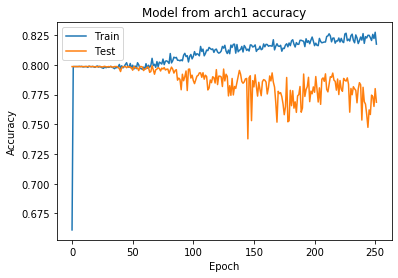

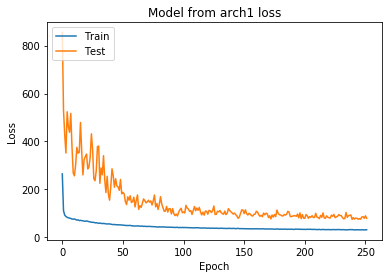

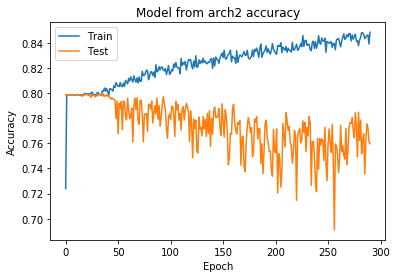

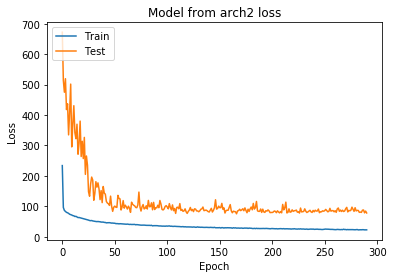

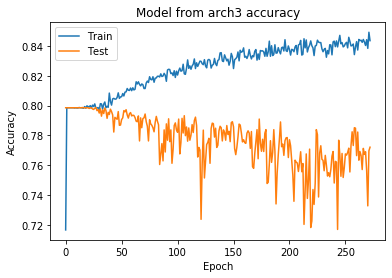

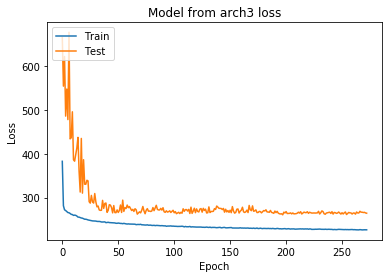

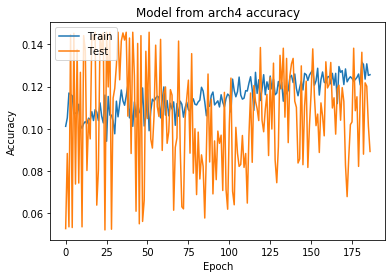

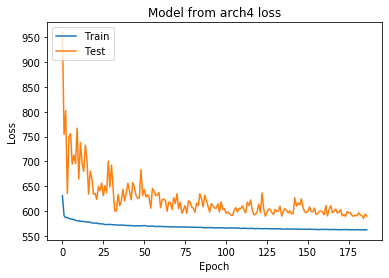

In [16]:
import matplotlib.pyplot as plt

for (key, result) in results.items():
    history = result["history"]
    arch = key.split('-')[0]
    # Plot training & validation accuracy values
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title(f'Model from {arch} accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')
    plt.show()

    # Plot training & validation loss values
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title(f'Model from {arch} loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')
    plt.show()

## Análisis resultados segunda iteración

Se evidencia una mejora en la función de pérdida notable para la arquitectura uno y dos, las arquitecturas 3 y 4 son descartadas debido a su pobre exactitud y evolución en la función de pérdida.

Sin embargo, la pérdida aún es muy alta para los mejores resultados, y visualmente no se ve que se pueda mejorar aumentando con más epocas el entrenamiento.

Veamos los resultados sobre algunas imágenes de prueba

In [21]:
paths = ["cat-dataset/CAT_02/00000656_017.jpg",
         "cat-dataset/CAT_05/00001170_012.jpg",
         "cat-dataset/CAT_05/00001127_003.jpg"]

model_arch1 = results_iter2["arch1-False"]["model"]

for path in paths:
    print(path)
    img = cv2.imread(path)
    img_resized = cv2.resize(img, (64, 64))
    true_points = tools.retrieve_face_coordinates(path)
    true_left_eye = tools.get_resized_eye_point_position(img, img_resized, true_points["left-eye"])
    true_right_eye = tools.get_resized_eye_point_position(img, img_resized, true_points["right-eye"])
    rsz = cv2.resize(img, (64, 64))
    testing = rsz.reshape((1, 64, 64, 3))
    
    coordinates = model_arch1.predict(testing)
    print(f"predicted: {coordinates}")
    print(f"grount truth: {true_left_eye}, {true_right_eye}")
    left_eye = (int(coordinates[0][0]), int(coordinates[0][1]))
    right_eye = (int(coordinates[0][2]), int(coordinates[0][3]))

cat-dataset/CAT_02/00000656_017.jpg
predicted: [[32.868793 19.637259 36.986748 20.650393]]
grount truth: (34, 27), (41, 26)
cat-dataset/CAT_05/00001170_012.jpg
predicted: [[27.470345 31.59046  38.091248 31.591864]]
grount truth: (31, 24), (39, 23)
cat-dataset/CAT_05/00001127_003.jpg
predicted: [[28.696583 24.067822 39.631084 25.183823]]
grount truth: (17, 30), (32, 28)


In [23]:
paths = ["cat-dataset/CAT_02/00000656_017.jpg",
         "cat-dataset/CAT_05/00001170_012.jpg",
         "cat-dataset/CAT_05/00001127_003.jpg"]

model_arch1 = results_iter2["arch2-False"]["model"]

for path in paths:
    print(path)
    img = cv2.imread(path)
    img_resized = cv2.resize(img, (64, 64))
    true_points = tools.retrieve_face_coordinates(path)
    true_left_eye = tools.get_resized_eye_point_position(img, img_resized, true_points["left-eye"])
    true_right_eye = tools.get_resized_eye_point_position(img, img_resized, true_points["right-eye"])
    rsz = cv2.resize(img, (64, 64))
    testing = rsz.reshape((1, 64, 64, 3))
    
    coordinates = model_arch1.predict(testing)
    print(f"predicted: {coordinates}")
    print(f"grount truth: {true_left_eye}, {true_right_eye}")
    left_eye = (int(coordinates[0][0]), int(coordinates[0][1]))
    right_eye = (int(coordinates[0][2]), int(coordinates[0][3]))

cat-dataset/CAT_02/00000656_017.jpg
predicted: [[35.718727 30.661947 39.709362 31.108068]]
grount truth: (34, 27), (41, 26)
cat-dataset/CAT_05/00001170_012.jpg
predicted: [[26.645136 33.4293   37.30678  35.26084 ]]
grount truth: (31, 24), (39, 23)
cat-dataset/CAT_05/00001127_003.jpg
predicted: [[22.051613 32.74112  31.060345 30.872707]]
grount truth: (17, 30), (32, 28)


## Análisis iteración

En general, los resultados de la previsión demuestran que hay un error de +-5px con algunas predicciones, lo cual hace sentido de acuerdo al mse obtenido durante el entrenamiento

In [7]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import TensorBoard, ModelCheckpoint, ReduceLROnPlateau

img_size = 64
inputs = Input(shape=(img_size, img_size, 3))
model = Sequential()
    
# Say not to train first layer (ResNet) model as it is already trained
model.add(MobileNetV2(input_shape=(img_size, img_size, 3), alpha=1.0, include_top=False, weights='imagenet', input_tensor=inputs, pooling='max'))
model.layers[0].trainable = False
model.add(Dense(128, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(4, activation='relu'))

model.summary()

/home/jota/.virtualenvs/crp/lib/python3.7/site-packages/keras_applications/mobilenet_v2.py:294: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  warnings.warn('`input_shape` is undefined or non-square, '


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_224 (Model) (None, 1280)              2257984   
_________________________________________________________________
dense (Dense)                (None, 128)               163968    
_________________________________________________________________
dense_1 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_2 (Dense)              (None, 4)                 260       
Total params: 2,430,468
Trainable params: 172,484
Non-trainable params: 2,257,984
_________________________________________________________________


In [19]:
# training
start_time = datetime.datetime.now().strftime('%Y_%m_%d_%H_%M_%S')
model.compile(optimizer="adam", loss="mse", metrics=["mse", "accuracy"])

history = model.fit(X_train, y_train, epochs=50, batch_size=32, shuffle=True,
  validation_data=(X_test, y_test), verbose=1,
  callbacks=[
    TensorBoard(log_dir='logs/%s' % (start_time)),
    ModelCheckpoint('./models/%s.h5' % (start_time), monitor='val_loss', verbose=1, save_best_only=True, mode='auto'),
    ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, verbose=1, mode='auto')
  ]
)

Train on 6200 samples, validate on 1550 samples
Epoch 1/50
6112/6200 [============================>.] - ETA: 0s - loss: 175.6364 - mse: 175.6365 - accuracy: 0.7904
Epoch 00001: val_loss improved from inf to 101.24270, saving model to ./models/2020_03_12_14_07_49.h5
6200/6200 [==============================] - 6s 945us/sample - loss: 174.4180 - mse: 174.4181 - accuracy: 0.7905 - val_loss: 101.2427 - val_mse: 101.2427 - val_accuracy: 0.7910
Epoch 2/50
6144/6200 [============================>.] - ETA: 0s - loss: 100.7202 - mse: 100.7202 - accuracy: 0.7977
Epoch 00002: val_loss did not improve from 101.24270
6200/6200 [==============================] - 4s 648us/sample - loss: 100.7651 - mse: 100.7651 - accuracy: 0.7981 - val_loss: 106.8269 - val_mse: 106.8269 - val_accuracy: 0.7910
Epoch 3/50
6144/6200 [============================>.] - ETA: 0s - loss: 92.0059 - mse: 92.0060 - accuracy: 0.7982
Epoch 00003: val_loss did not improve from 101.24270
6200/6200 [==============================] -

Epoch 24/50
6080/6200 [============================>.] - ETA: 0s - loss: 47.6562 - mse: 47.6561 - accuracy: 0.7984
Epoch 00024: val_loss did not improve from 69.53750
6200/6200 [==============================] - 4s 602us/sample - loss: 47.5887 - mse: 47.5886 - accuracy: 0.7976 - val_loss: 70.7821 - val_mse: 70.7821 - val_accuracy: 0.7910
Epoch 25/50
6176/6200 [============================>.] - ETA: 0s - loss: 46.4049 - mse: 46.4049 - accuracy: 0.8005
Epoch 00025: val_loss did not improve from 69.53750
6200/6200 [==============================] - 4s 615us/sample - loss: 46.3792 - mse: 46.3792 - accuracy: 0.8005 - val_loss: 70.8596 - val_mse: 70.8596 - val_accuracy: 0.7910
Epoch 26/50
6176/6200 [============================>.] - ETA: 0s - loss: 46.8126 - mse: 46.8126 - accuracy: 0.7979
Epoch 00026: val_loss did not improve from 69.53750
6200/6200 [==============================] - 4s 643us/sample - loss: 46.7455 - mse: 46.7455 - accuracy: 0.7981 - val_loss: 70.3738 - val_mse: 70.3738 - v

In [20]:
model.evaluate(X_test, y_test)

1550/1550 [==============================] - 1s 454us/sample - loss: 70.3373 - mse: 70.3373 - accuracy: 0.7910


[70.33727917578912, 70.33728, 0.79096776]

In [21]:
# Saves the last iteration in a custom var
results_3 = {"model": model, "history": history}

## Probando otros modelos

La respuesta con ResNet50 hasta ahora no es muy buena, y Keras tiene disponible otros modelos, así que intentemos con mobilenet con una iteración de pocas épocas

In [27]:
# ********************************
# Training with Data augmentation
# ********************************

datagen = ImageDataGenerator(
    featurewise_center=True,
    featurewise_std_normalization=True,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True)

batches = 32
epochs = 50

train_generator = datagen.flow(X_train, y_train, batch_size=batches)
validation_generator = datagen.flow(X_train, y_train, batch_size=batches)

model = Sequential()

# Say not to train first layer (ResNet) model as it is already trained
model.add(MobileNetV2(input_shape=(img_size, img_size, 3), alpha=1.0, include_top=False, weights='imagenet', input_tensor=inputs, pooling='max'))
model.layers[0].trainable = False
model.add(Dense(128, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(4, activation='relu'))

model.compile(optimizer="adam", loss="mse", metrics=["mse", "accuracy"])

# training
start_time = datetime.datetime.now().strftime('%Y_%m_%d_%H_%M_%S')
model.compile(optimizer="adam", loss="mse", metrics=["mse", "accuracy"])

history = model.fit_generator(train_generator,
                              validation_data=validation_generator,
                              epochs=epochs, shuffle=True,
                              verbose=1,
                              callbacks=[
                                TensorBoard(log_dir='logs/%s' % (start_time)),
                                ModelCheckpoint('./models/%s.h5' % (start_time), monitor='val_loss', verbose=1, save_best_only=True, mode='auto'),
                                ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, verbose=1, mode='auto')
                              ]
                             )

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 194 steps, validate for 194 steps
Epoch 1/50
193/194 [============================>.] - ETA: 0s - loss: 227.0987 - mse: 227.0673 - accuracy: 0.6341
Epoch 00001: val_loss improved from inf to 171.34072, saving model to ./models/2020_03_12_14_22_47.h5
194/194 [==============================] - 12s 63ms/step - loss: 226.5996 - mse: 226.5678 - accuracy: 0.6348 - val_loss: 171.3407 - val_mse: 171.3228 - val_accuracy: 0.7985
Epoch 2/50
192/194 [============================>.] - ETA: 0s - loss: 108.4294 - mse: 108.4064 - accuracy: 0.7987
Epoch 00002: val_loss improved from 171.34072 to 135.63797, saving model to ./models/2020_03_12_14_22_47.h5
194/194 [==============================] - 11s 54ms/step - loss: 108.4846 - mse: 108.4620 - accuracy: 0.7985 - val_loss: 135.6380 - val_mse: 135.6146 - val_accuracy: 0.7985
Epoch 3/50
193/194 [============================>.] - ETA: 0s - loss: 98.2908 - mse: 98.2667 - accuracy: 0.7983
Epoch 0000

Epoch 24/50
192/194 [============================>.] - ETA: 0s - loss: 63.1681 - mse: 63.1882 - accuracy: 0.8000
Epoch 00024: val_loss did not improve from 70.65087
194/194 [==============================] - 11s 56ms/step - loss: 63.1932 - mse: 63.2130 - accuracy: 0.7985 - val_loss: 81.6026 - val_mse: 81.5884 - val_accuracy: 0.7985
Epoch 25/50
192/194 [============================>.] - ETA: 0s - loss: 62.3735 - mse: 62.3862 - accuracy: 0.7986
Epoch 00025: val_loss did not improve from 70.65087
194/194 [==============================] - 11s 56ms/step - loss: 62.3743 - mse: 62.3869 - accuracy: 0.7985 - val_loss: 77.1764 - val_mse: 77.1672 - val_accuracy: 0.7985
Epoch 26/50
192/194 [============================>.] - ETA: 0s - loss: 62.2929 - mse: 62.2950 - accuracy: 0.7989
Epoch 00026: val_loss did not improve from 70.65087
194/194 [==============================] - 11s 56ms/step - loss: 62.2416 - mse: 62.2436 - accuracy: 0.7985 - val_loss: 73.0896 - val_mse: 73.0808 - val_accuracy: 0.798

Epoch 48/50
192/194 [============================>.] - ETA: 0s - loss: 60.9315 - mse: 60.9421 - accuracy: 0.7982
Epoch 00048: val_loss did not improve from 70.65087
194/194 [==============================] - 11s 55ms/step - loss: 60.8840 - mse: 60.8944 - accuracy: 0.7985 - val_loss: 73.0676 - val_mse: 73.0612 - val_accuracy: 0.7985
Epoch 49/50
193/194 [============================>.] - ETA: 0s - loss: 61.0693 - mse: 61.0809 - accuracy: 0.7993
Epoch 00049: val_loss did not improve from 70.65087
194/194 [==============================] - 10s 54ms/step - loss: 61.1240 - mse: 61.1355 - accuracy: 0.7985 - val_loss: 73.3854 - val_mse: 73.3691 - val_accuracy: 0.7985
Epoch 50/50
193/194 [============================>.] - ETA: 0s - loss: 60.6734 - mse: 60.6721 - accuracy: 0.7991
Epoch 00050: val_loss did not improve from 70.65087
194/194 [==============================] - 10s 53ms/step - loss: 60.6871 - mse: 60.6859 - accuracy: 0.7984 - val_loss: 73.1530 - val_mse: 73.1541 - val_accuracy: 0.798

In [28]:
model.evaluate(X_test, y_test)
# Saves the last iteration in a custom var
results_4 = {"model": model, "history": history}

1550/1550 [==============================] - 1s 805us/sample - loss: 74.8249 - mse: 74.8249 - accuracy: 0.7910


In [29]:
inputs = Input(shape=(img_size, img_size, 3))
img_size = 64
model = Sequential()
    
# Say not to train first layer (ResNet) model as it is already trained
model.add(MobileNetV2(input_shape=(img_size, img_size, 3), alpha=1.0, include_top=False, weights='imagenet', input_tensor=inputs, pooling='max'))
model.layers[0].trainable = False
model.add(Dense(128, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(4, activation='relu'))

# training
start_time = datetime.datetime.now().strftime('%Y_%m_%d_%H_%M_%S')
model.compile(optimizer="adam", loss="mse", metrics=["mse"])

history = model.fit(X_train, y_train, epochs=50, batch_size=32, shuffle=True,
  validation_data=(X_test, y_test), verbose=1,
  callbacks=[
    TensorBoard(log_dir='logs/%s' % (start_time)),
    ModelCheckpoint('./models/%s.h5' % (start_time), monitor='val_loss', verbose=1, save_best_only=True, mode='auto'),
    ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, verbose=1, mode='auto')
  ]
)

Train on 6200 samples, validate on 1550 samples
Epoch 1/50
6080/6200 [============================>.] - ETA: 0s - loss: 168.6676 - mse: 168.6676
Epoch 00001: val_loss improved from inf to 122.04900, saving model to ./models/2020_03_12_14_31_57.h5
6200/6200 [==============================] - 6s 899us/sample - loss: 167.5479 - mse: 167.5480 - val_loss: 122.0490 - val_mse: 122.0490
Epoch 2/50
6176/6200 [============================>.] - ETA: 0s - loss: 102.7247 - mse: 102.7247
Epoch 00002: val_loss improved from 122.04900 to 118.08145, saving model to ./models/2020_03_12_14_31_57.h5
6200/6200 [==============================] - 4s 617us/sample - loss: 102.6761 - mse: 102.6762 - val_loss: 118.0815 - val_mse: 118.0815
Epoch 3/50
6176/6200 [============================>.] - ETA: 0s - loss: 89.4665 - mse: 89.4665
Epoch 00003: val_loss improved from 118.08145 to 112.92516, saving model to ./models/2020_03_12_14_31_57.h5
6200/6200 [==============================] - 4s 615us/sample - loss: 89.558

Epoch 28/50
6112/6200 [============================>.] - ETA: 0s - loss: 50.2513 - mse: 50.2513
Epoch 00028: val_loss did not improve from 71.60898

Epoch 00028: ReduceLROnPlateau reducing learning rate to 4.0000001899898055e-05.
6200/6200 [==============================] - 4s 622us/sample - loss: 50.2975 - mse: 50.2975 - val_loss: 73.9710 - val_mse: 73.9710
Epoch 29/50
6176/6200 [============================>.] - ETA: 0s - loss: 49.9914 - mse: 49.9913
Epoch 00029: val_loss did not improve from 71.60898
6200/6200 [==============================] - 4s 620us/sample - loss: 50.0291 - mse: 50.0291 - val_loss: 76.0430 - val_mse: 76.0430
Epoch 30/50
6144/6200 [============================>.] - ETA: 0s - loss: 48.8833 - mse: 48.8833
Epoch 00030: val_loss did not improve from 71.60898
6200/6200 [==============================] - 4s 626us/sample - loss: 48.9574 - mse: 48.9574 - val_loss: 75.4344 - val_mse: 75.4344
Epoch 31/50
6112/6200 [============================>.] - ETA: 0s - loss: 48.8417 

In [37]:
model.evaluate(X_test, y_test)
# Saves the last iteration in a custom var
results_5 = {"model": model, "history": history}


1550/1550 [==============================] - 1s 472us/sample - loss: 59.7148 - mse: 59.7148 - accuracy: 0.7735


## Análisis de iteración

Para pocas épocas la mejora no es notable con respecto a resnet50. Probemos quitando la capa final de salida del modelo y agregando capas adicionales. También quitemos como parámetro de entrenamiento la exactitud y quedemonos solo con la pérdida


In [20]:
from tensorflow.keras.models import Model

inputs = Input(shape=(img_size, img_size, 3))
output_size = 4

mobilenetv2_model = MobileNetV2(input_shape=(img_size, img_size, 3),
                                alpha=1.0,
                                include_top=False,
                                weights='imagenet',
                                input_tensor=inputs,
                                pooling='max')
net = Dense(128, activation='relu')(mobilenetv2_model.layers[-1].output)
net = Dense(64, activation='relu')(net)
net = Dense(output_size, activation='linear')(net)


model = Model(inputs=inputs, outputs=net)
model.summary()

# training
start_time = datetime.datetime.now().strftime('%Y_%m_%d_%H_%M_%S')
model.compile(optimizer="adam", loss="mse", metrics=["mse"])

history = model.fit(X_train, y_train, epochs=50, batch_size=32, shuffle=True,
  validation_data=(X_test, y_test), verbose=1,
  callbacks=[
    TensorBoard(log_dir='logs/%s' % (start_time)),
    ModelCheckpoint('./models/%s.h5' % (start_time), monitor='val_loss', verbose=1, save_best_only=True, mode='auto'),
    ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, verbose=1, mode='auto')
  ]
)

Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            [(None, 64, 64, 3)]  0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 65, 65, 3)    0           input_7[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 32, 32, 32)   864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 32, 32, 32)   128         Conv1[0][0]                      
____________________________________________________________________________________________

Epoch 1/50
6144/6200 [============================>.] - ETA: 0s - loss: 95.4495 - mse: 95.4495
Epoch 00001: val_loss improved from inf to 2124.60961, saving model to ./models/2020_03_12_21_18_17.h5
6200/6200 [==============================] - 13s 2ms/sample - loss: 94.8840 - mse: 94.8840 - val_loss: 2124.6096 - val_mse: 2124.6091
Epoch 2/50
6176/6200 [============================>.] - ETA: 0s - loss: 35.3136 - mse: 35.3136
Epoch 00002: val_loss improved from 2124.60961 to 1257.77941, saving model to ./models/2020_03_12_21_18_17.h5
6200/6200 [==============================] - 10s 2ms/sample - loss: 35.3019 - mse: 35.3019 - val_loss: 1257.7794 - val_mse: 1257.7792
Epoch 3/50
6176/6200 [============================>.] - ETA: 0s - loss: 25.1817 - mse: 25.1817
Epoch 00003: val_loss improved from 1257.77941 to 820.23932, saving model to ./models/2020_03_12_21_18_17.h5
6200/6200 [==============================] - 10s 2ms/sample - loss: 25.1596 - mse: 25.1596 - val_loss: 820.2393 - val_mse: 82

6176/6200 [============================>.] - ETA: 0s - loss: 1.9123 - mse: 1.9123
Epoch 00027: val_loss improved from 17.19398 to 16.20259, saving model to ./models/2020_03_12_21_18_17.h5
6200/6200 [==============================] - 10s 2ms/sample - loss: 1.9190 - mse: 1.9190 - val_loss: 16.2026 - val_mse: 16.2026
Epoch 28/50
6176/6200 [============================>.] - ETA: 0s - loss: 1.8710 - mse: 1.8710
Epoch 00028: val_loss improved from 16.20259 to 16.17349, saving model to ./models/2020_03_12_21_18_17.h5
6200/6200 [==============================] - 9s 2ms/sample - loss: 1.8706 - mse: 1.8706 - val_loss: 16.1735 - val_mse: 16.1735
Epoch 29/50
6176/6200 [============================>.] - ETA: 0s - loss: 1.8168 - mse: 1.8168
Epoch 00029: val_loss did not improve from 16.17349
6200/6200 [==============================] - 10s 2ms/sample - loss: 1.8164 - mse: 1.8164 - val_loss: 17.0989 - val_mse: 17.0989
Epoch 30/50
6144/6200 [============================>.] - ETA: 0s - loss: 1.6558 - m

In [21]:
model.evaluate(X_test, y_test)
# Saves the last iteration in a custom var
results_6 = {"model": model, "history": history}

1550/1550 [==============================] - 1s 436us/sample - loss: 16.0761 - mse: 16.0761


In [22]:
# ********************************
# Training with Data augmentation
# ********************************

datagen = ImageDataGenerator(
    featurewise_center=True,
    featurewise_std_normalization=True,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True)

batches = 32
epochs = 50

train_generator = datagen.flow(X_train, y_train, batch_size=batches)
validation_generator = datagen.flow(X_train, y_train, batch_size=batches)

inputs = Input(shape=(img_size, img_size, 3))
output_size = 4

mobilenetv2_model = MobileNetV2(input_shape=(img_size, img_size, 3),
                                alpha=1.0,
                                include_top=False,
                                weights='imagenet',
                                input_tensor=inputs,
                                pooling='max')
net = Dense(128, activation='relu')(mobilenetv2_model.layers[-1].output)
net = Dense(64, activation='relu')(net)
net = Dense(output_size, activation='linear')(net)

model = Model(inputs=inputs, outputs=net)

# training
start_time = datetime.datetime.now().strftime('%Y_%m_%d_%H_%M_%S')
model.compile(optimizer="adam", loss="mse", metrics=["mse"])

history = model.fit_generator(train_generator,
                              validation_data=validation_generator,
                              epochs=epochs, shuffle=True,
                              verbose=1,
                              callbacks=[
                                TensorBoard(log_dir='logs/%s' % (start_time)),
                                ModelCheckpoint('./models/%s.h5' % (start_time), monitor='val_loss', verbose=1, save_best_only=True, mode='auto'),
                                ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, verbose=1, mode='auto')
                              ]
                             )

Instructions for updating:
Please use Model.fit, which supports generators.
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 194 steps, validate for 194 steps


/home/jota/.virtualenvs/crp/lib/python3.7/site-packages/keras_preprocessing/image/image_data_generator.py:716: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/home/jota/.virtualenvs/crp/lib/python3.7/site-packages/keras_preprocessing/image/image_data_generator.py:724: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


Epoch 1/50
192/194 [============================>.] - ETA: 0s - loss: 108.7044 - mse: 108.7706
Epoch 00001: val_loss improved from inf to 108.86713, saving model to ./models/2020_03_12_21_26_25.h5
194/194 [==============================] - 18s 92ms/step - loss: 108.4708 - mse: 108.5357 - val_loss: 108.8671 - val_mse: 108.8636
Epoch 2/50
193/194 [============================>.] - ETA: 0s - loss: 66.5352 - mse: 66.5395
Epoch 00002: val_loss did not improve from 108.86713
194/194 [==============================] - 14s 71ms/step - loss: 66.4870 - mse: 66.4912 - val_loss: 457.4748 - val_mse: 457.4335
Epoch 3/50
193/194 [============================>.] - ETA: 0s - loss: 60.0827 - mse: 60.0806
Epoch 00003: val_loss did not improve from 108.86713
194/194 [==============================] - 13s 68ms/step - loss: 60.2380 - mse: 60.2360 - val_loss: 494.3934 - val_mse: 494.3642
Epoch 4/50
193/194 [============================>.] - ETA: 0s - loss: 56.5943 - mse: 56.6141
Epoch 00004: val_loss did not

194/194 [==============================] - 15s 78ms/step - loss: 36.7889 - mse: 36.8033 - val_loss: 42.3418 - val_mse: 42.3155
Epoch 29/50
192/194 [============================>.] - ETA: 0s - loss: 36.5631 - mse: 36.5865
Epoch 00029: val_loss improved from 42.34181 to 42.22486, saving model to ./models/2020_03_12_21_26_25.h5
194/194 [==============================] - 14s 74ms/step - loss: 36.6114 - mse: 36.6344 - val_loss: 42.2249 - val_mse: 42.2054
Epoch 30/50
193/194 [============================>.] - ETA: 0s - loss: 36.8553 - mse: 36.8682
Epoch 00030: val_loss improved from 42.22486 to 41.52367, saving model to ./models/2020_03_12_21_26_25.h5
194/194 [==============================] - 14s 74ms/step - loss: 36.8374 - mse: 36.8501 - val_loss: 41.5237 - val_mse: 41.4989
Epoch 31/50
193/194 [============================>.] - ETA: 0s - loss: 36.2884 - mse: 36.2976
Epoch 00031: val_loss improved from 41.52367 to 41.13802, saving model to ./models/2020_03_12_21_26_25.h5
194/194 [==========

In [24]:
model.evaluate(X_test, y_test)
# Saves the last iteration in a custom var
results_7 = {"model": model, "history": history}

1550/1550 [==============================] - 1s 466us/sample - loss: 63.7909 - mse: 63.7909


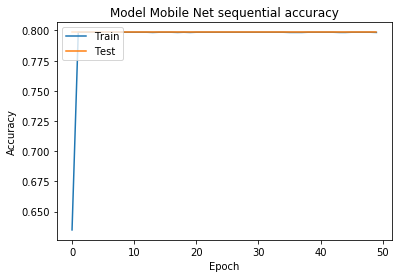

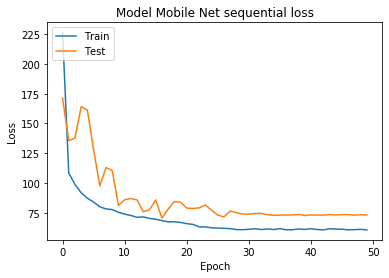

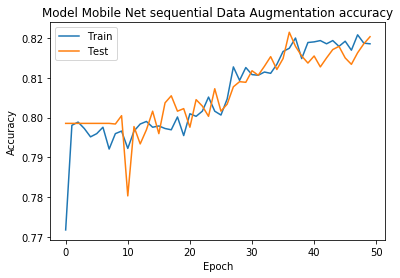

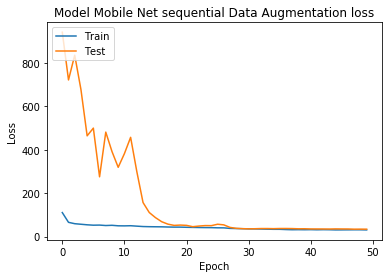

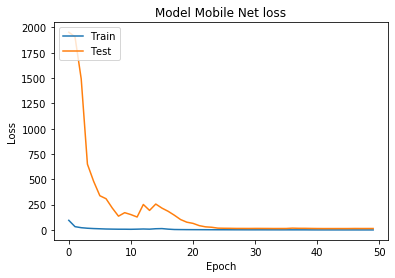

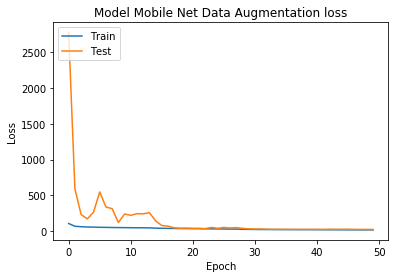

In [43]:
import matplotlib.pyplot as plt
results = [results_4, results_5, results_6, results_7]

history = results_4["history"]

# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Mobile Net sequential accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Mobile Net sequential loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

history = results_5["history"]

# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Mobile Net sequential Data Augmentation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Mobile Net sequential Data Augmentation loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

history = results_6["history"]


# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Mobile Net loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

history = results_7["history"]


# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Mobile Net Data Augmentation loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

## Análisis de iteración

El módelo de MobileNet da un resultado mucho mejor que las implementaciones que llevamos hasta ahora con ResNet50 haciendo el cambio de modelo secuencial a cortar la última capa y reemplazarla, sin necesidad de realizar Data Augmentation; esto último da como resultado un modelo peor. Probemos usando la misma arquitectura pero con ResNet50


In [14]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model

inputs = Input(shape=(img_size, img_size, 3))
output_size = 4

resnet50_model = ResNet50(input_shape=(img_size, img_size, 3),
                                include_top=False,
                                weights='imagenet',
                                input_tensor=inputs,
                                pooling='max')
net = Dense(128, activation='relu')(resnet50_model.layers[-1].output)
net = Dense(64, activation='relu')(net)
net = Dense(output_size, activation='linear')(net)


model = Model(inputs=inputs, outputs=net)
model.summary()

# training
start_time = datetime.datetime.now().strftime('%Y_%m_%d_%H_%M_%S')
model.compile(optimizer="adam", loss="mse", metrics=["mse"])

history = model.fit(X_train, y_train, epochs=50, batch_size=32, shuffle=True,
  validation_data=(X_test, y_test), verbose=1,
  callbacks=[
    TensorBoard(log_dir='logs/%s' % (start_time)),
    ModelCheckpoint('./models/%s.h5' % (start_time), monitor='val_loss', verbose=1, save_best_only=True, mode='auto'),
    ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, verbose=1, mode='auto')
  ]
)



Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 64, 64, 3)]  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 70, 70, 3)    0           input_3[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 32, 32, 64)   9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 32, 32, 64)   256         conv1_conv[0][0]                 
____________________________________________________________________________________________

Epoch 1/50
6176/6200 [============================>.] - ETA: 0s - loss: 72.7456 - mse: 72.7456
Epoch 00001: val_loss improved from inf to 151.64337, saving model to ./models/2020_03_12_20_54_23.h5
6200/6200 [==============================] - 34s 5ms/sample - loss: 72.5167 - mse: 72.5167 - val_loss: 151.6434 - val_mse: 151.6434
Epoch 2/50
6176/6200 [============================>.] - ETA: 0s - loss: 24.4525 - mse: 24.4525
Epoch 00002: val_loss improved from 151.64337 to 41.35684, saving model to ./models/2020_03_12_20_54_23.h5
6200/6200 [==============================] - 29s 5ms/sample - loss: 24.4282 - mse: 24.4282 - val_loss: 41.3568 - val_mse: 41.3568
Epoch 3/50
6176/6200 [============================>.] - ETA: 0s - loss: 17.4915 - mse: 17.4915
Epoch 00003: val_loss improved from 41.35684 to 29.50650, saving model to ./models/2020_03_12_20_54_23.h5
6200/6200 [==============================] - 29s 5ms/sample - loss: 17.5012 - mse: 17.5012 - val_loss: 29.5065 - val_mse: 29.5065
Epoch 4/

KeyboardInterrupt: 

In [52]:
model.evaluate(X_test, y_test)
# Saves the last iteration in a custom var
results_8 = {"model": model, "history": history}

1550/1550 [==============================] - 2s 1ms/sample - loss: 17.3702 - mse: 17.3702


In [53]:
# ********************************
# Training with Data augmentation
# ********************************

datagen = ImageDataGenerator(
    featurewise_center=True,
    featurewise_std_normalization=True,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True)

batches = 32
epochs = 50

train_generator = datagen.flow(X_train, y_train, batch_size=batches)
validation_generator = datagen.flow(X_train, y_train, batch_size=batches)

inputs = Input(shape=(img_size, img_size, 3))
output_size = 4

mobilenetv2_model = MobileNetV2(input_shape=(img_size, img_size, 3),
                                alpha=1.0,
                                include_top=False,
                                weights='imagenet',
                                input_tensor=inputs,
                                pooling='max')
net = Dense(128, activation='relu')(mobilenetv2_model.layers[-1].output)
net = Dense(64, activation='relu')(net)
net = Dense(output_size, activation='linear')(net)

model = Model(inputs=inputs, outputs=net)

# training
start_time = datetime.datetime.now().strftime('%Y_%m_%d_%H_%M_%S')
model.compile(optimizer="adam", loss="mse", metrics=["mse"])

history = model.fit_generator(train_generator,
                              validation_data=validation_generator,
                              epochs=epochs, shuffle=True,
                              verbose=1,
                              callbacks=[
                                TensorBoard(log_dir='logs/%s' % (start_time)),
                                ModelCheckpoint('./models/%s.h5' % (start_time), monitor='val_loss', verbose=1, save_best_only=True, mode='auto'),
                                ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, verbose=1, mode='auto')
                              ]
                             )

/home/jota/.virtualenvs/crp/lib/python3.7/site-packages/keras_applications/mobilenet_v2.py:294: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  warnings.warn('`input_shape` is undefined or non-square, '


  ...
    to  
  ['...']
  ...
    to  
  ['...']


/home/jota/.virtualenvs/crp/lib/python3.7/site-packages/keras_preprocessing/image/image_data_generator.py:716: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/home/jota/.virtualenvs/crp/lib/python3.7/site-packages/keras_preprocessing/image/image_data_generator.py:724: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


Train for 194 steps, validate for 194 steps
Epoch 1/50
193/194 [============================>.] - ETA: 0s - loss: 105.4606 - mse: 105.5055
Epoch 00001: val_loss improved from inf to 1065.05943, saving model to ./models/2020_03_12_16_07_24.h5
194/194 [==============================] - 20s 104ms/step - loss: 105.4080 - mse: 105.4525 - val_loss: 1065.0594 - val_mse: 1064.9086
Epoch 2/50
193/194 [============================>.] - ETA: 0s - loss: 66.7561 - mse: 66.7628
Epoch 00002: val_loss improved from 1065.05943 to 1002.88331, saving model to ./models/2020_03_12_16_07_24.h5
194/194 [==============================] - 16s 81ms/step - loss: 66.7281 - mse: 66.7348 - val_loss: 1002.8833 - val_mse: 1003.0327
Epoch 3/50
193/194 [============================>.] - ETA: 0s - loss: 60.5166 - mse: 60.5140
Epoch 00003: val_loss improved from 1002.88331 to 730.64313, saving model to ./models/2020_03_12_16_07_24.h5
194/194 [==============================] - 15s 78ms/step - loss: 60.5381 - mse: 60.5356 

Epoch 28/50
192/194 [============================>.] - ETA: 0s - loss: 32.8817 - mse: 32.8817
Epoch 00028: val_loss improved from 46.24054 to 39.01663, saving model to ./models/2020_03_12_16_07_24.h5
194/194 [==============================] - 15s 79ms/step - loss: 32.9222 - mse: 32.9223 - val_loss: 39.0166 - val_mse: 39.0214
Epoch 29/50
192/194 [============================>.] - ETA: 0s - loss: 32.3019 - mse: 32.2946
Epoch 00029: val_loss did not improve from 39.01663
194/194 [==============================] - 15s 75ms/step - loss: 32.2308 - mse: 32.2236 - val_loss: 40.0771 - val_mse: 40.0890
Epoch 30/50
193/194 [============================>.] - ETA: 0s - loss: 31.2819 - mse: 31.2776
Epoch 00030: val_loss improved from 39.01663 to 36.99974, saving model to ./models/2020_03_12_16_07_24.h5
194/194 [==============================] - 15s 79ms/step - loss: 31.3077 - mse: 31.3035 - val_loss: 36.9997 - val_mse: 37.0078
Epoch 31/50
193/194 [============================>.] - ETA: 0s - loss: 29

In [54]:
model.evaluate(X_test, y_test)
# Saves the last iteration in a custom var
results_9 = {"model": model, "history": history}

1550/1550 [==============================] - 1s 844us/sample - loss: 70.4215 - mse: 70.4215


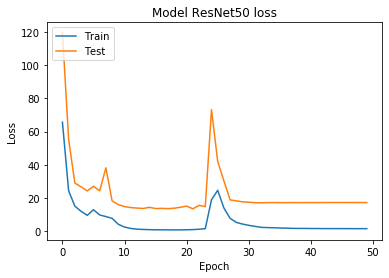

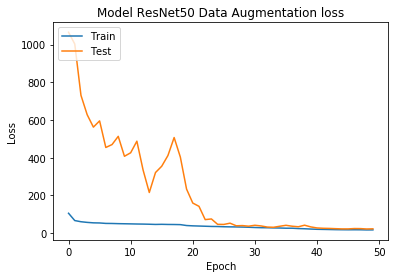

In [55]:
history = results_8["history"]

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model ResNet50 loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

history = results_9["history"]

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model ResNet50 Data Augmentation loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()


## Análisis de iteración

No se evidencia una mejora considerable contra las iteraciones previas de ResNet50. Evidenciemos algunos ejemplos de predicción

In [57]:
paths = ["cat-dataset/CAT_02/00000656_017.jpg",
         "cat-dataset/CAT_05/00001170_012.jpg",
         "cat-dataset/CAT_05/00001127_003.jpg"]

model_arch1 = results_6["model"]
print("********* MobileNet No Data Augmentation predictions ************")
for path in paths:
    print(path)
    img = cv2.imread(path)
    img_resized = cv2.resize(img, (64, 64))
    true_points = tools.retrieve_face_coordinates(path)
    true_left_eye = tools.get_resized_eye_point_position(img, img_resized, true_points["left-eye"])
    true_right_eye = tools.get_resized_eye_point_position(img, img_resized, true_points["right-eye"])
    rsz = cv2.resize(img, (64, 64))
    testing = rsz.reshape((1, 64, 64, 3))
    
    coordinates = model_arch1.predict(testing)
    print(f"predicted: {coordinates}")
    print(f"grount truth: {true_left_eye}, {true_right_eye}")
    left_eye = (int(coordinates[0][0]), int(coordinates[0][1]))
    right_eye = (int(coordinates[0][2]), int(coordinates[0][3]))

********* MobileNet No Data Augmentation predictions ************
cat-dataset/CAT_02/00000656_017.jpg
predicted: [[33.281345 26.729347 39.740597 25.047379]]
grount truth: (34, 27), (41, 26)
cat-dataset/CAT_05/00001170_012.jpg
predicted: [[30.020662 23.179457 35.82492  22.500605]]
grount truth: (31, 24), (39, 23)
cat-dataset/CAT_05/00001127_003.jpg
predicted: [[16.983583 29.200523 32.013447 27.272903]]
grount truth: (17, 30), (32, 28)


In [58]:
paths = ["cat-dataset/CAT_02/00000656_017.jpg",
         "cat-dataset/CAT_05/00001170_012.jpg",
         "cat-dataset/CAT_05/00001127_003.jpg"]

model_arch1 = results_7["model"]
print("********* MobileNet with Data Augmentation predictions ************")
for path in paths:
    print(path)
    img = cv2.imread(path)
    img_resized = cv2.resize(img, (64, 64))
    true_points = tools.retrieve_face_coordinates(path)
    true_left_eye = tools.get_resized_eye_point_position(img, img_resized, true_points["left-eye"])
    true_right_eye = tools.get_resized_eye_point_position(img, img_resized, true_points["right-eye"])
    rsz = cv2.resize(img, (64, 64))
    testing = rsz.reshape((1, 64, 64, 3))
    
    coordinates = model_arch1.predict(testing)
    print(f"predicted: {coordinates}")
    print(f"grount truth: {true_left_eye}, {true_right_eye}")
    left_eye = (int(coordinates[0][0]), int(coordinates[0][1]))
    right_eye = (int(coordinates[0][2]), int(coordinates[0][3]))

********* MobileNet with Data Augmentation predictions ************
cat-dataset/CAT_02/00000656_017.jpg
predicted: [[33.683292 24.552145 39.20576  24.78356 ]]
grount truth: (34, 27), (41, 26)
cat-dataset/CAT_05/00001170_012.jpg
predicted: [[28.791367 24.954853 36.702286 21.958336]]
grount truth: (31, 24), (39, 23)
cat-dataset/CAT_05/00001127_003.jpg
predicted: [[13.941769 26.753397 27.85342  24.75718 ]]
grount truth: (17, 30), (32, 28)


In [60]:
paths = ["cat-dataset/CAT_02/00000656_017.jpg",
         "cat-dataset/CAT_05/00001170_012.jpg",
         "cat-dataset/CAT_05/00001127_003.jpg"]

model_arch1 = results_8["model"]
print("********* ResNet50 No Data Augmentation predictions ************")
for path in paths:
    print(path)
    img = cv2.imread(path)
    img_resized = cv2.resize(img, (64, 64))
    true_points = tools.retrieve_face_coordinates(path)
    true_left_eye = tools.get_resized_eye_point_position(img, img_resized, true_points["left-eye"])
    true_right_eye = tools.get_resized_eye_point_position(img, img_resized, true_points["right-eye"])
    rsz = cv2.resize(img, (64, 64))
    testing = rsz.reshape((1, 64, 64, 3))
    
    coordinates = model_arch1.predict(testing)
    print(f"predicted: {coordinates}")
    print(f"grount truth: {true_left_eye}, {true_right_eye}")
    left_eye = (int(coordinates[0][0]), int(coordinates[0][1]))
    right_eye = (int(coordinates[0][2]), int(coordinates[0][3]))

********* ResNet50 No Data Augmentation predictions ************
cat-dataset/CAT_02/00000656_017.jpg
predicted: [[36.05229  24.161564 41.692173 24.036354]]
grount truth: (34, 27), (41, 26)
cat-dataset/CAT_05/00001170_012.jpg
predicted: [[27.430975 23.774475 36.339325 26.560043]]
grount truth: (31, 24), (39, 23)
cat-dataset/CAT_05/00001127_003.jpg
predicted: [[18.0096   30.666367 29.993742 27.964699]]
grount truth: (17, 30), (32, 28)


In [62]:
paths = ["cat-dataset/CAT_02/00000656_017.jpg",
         "cat-dataset/CAT_05/00001170_012.jpg",
         "cat-dataset/CAT_05/00001127_003.jpg"]

model_arch1 = results_9["model"]
print("********* ResNet50 With Data Augmentation predictions ************")
for path in paths:
    print(path)
    img = cv2.imread(path)
    img_resized = cv2.resize(img, (64, 64))
    true_points = tools.retrieve_face_coordinates(path)
    true_left_eye = tools.get_resized_eye_point_position(img, img_resized, true_points["left-eye"])
    true_right_eye = tools.get_resized_eye_point_position(img, img_resized, true_points["right-eye"])
    rsz = cv2.resize(img, (64, 64))
    testing = rsz.reshape((1, 64, 64, 3))
    
    coordinates = model_arch1.predict(testing)
    print(f"predicted: {coordinates}")
    print(f"grount truth: {true_left_eye}, {true_right_eye}")
    left_eye = (int(coordinates[0][0]), int(coordinates[0][1]))
    right_eye = (int(coordinates[0][2]), int(coordinates[0][3]))

********* ResNet50 With Data Augmentation predictions ************
cat-dataset/CAT_02/00000656_017.jpg
predicted: [[24.973545 23.727331 28.560078 23.41545 ]]
grount truth: (34, 27), (41, 26)
cat-dataset/CAT_05/00001170_012.jpg
predicted: [[31.807661 26.767887 35.516933 26.233961]]
grount truth: (31, 24), (39, 23)
cat-dataset/CAT_05/00001127_003.jpg
predicted: [[30.08427  32.449715 36.967075 33.764175]]
grount truth: (17, 30), (32, 28)


## Análisis Iteración

Por inspección visual de resultados de exactitud y pérdida, el modelo que mejor resultado da para el problema en particular es mobilenet sin hacer uso de la utilidad de data augmentation, luego será este el que utilizaremos. Veamos el resultado visual final

cat-dataset/CAT_02/00000656_017.jpg
predicted: [[33.170006 26.652687 39.879642 25.06725 ]]
grount truth: (34, 27), (41, 26)


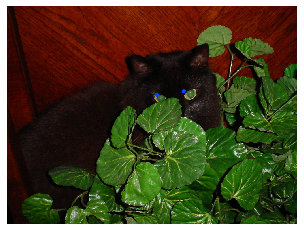

cat-dataset/CAT_05/00001170_012.jpg
predicted: [[28.451038 24.42968  36.349766 23.528393]]
grount truth: (31, 24), (39, 23)


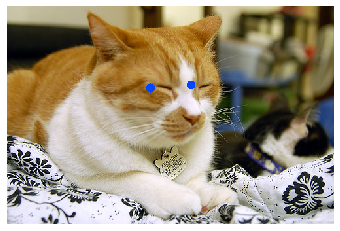

cat-dataset/CAT_05/00001127_003.jpg
predicted: [[16.06986  29.066805 30.050817 26.615099]]
grount truth: (17, 30), (32, 28)


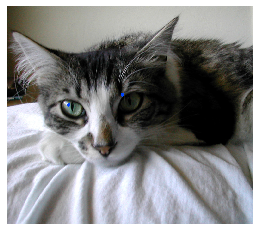

In [28]:
# Let's show the image to see how this array 'looks'
%matplotlib inline
best_model = results_6["model"]

paths = ["cat-dataset/CAT_02/00000656_017.jpg",
         "cat-dataset/CAT_05/00001170_012.jpg",
         "cat-dataset/CAT_05/00001127_003.jpg",]

index = 1

for path in paths:
    print(path)
    img = cv2.imread(path)
    img_resized = cv2.resize(img, (64, 64))
    true_points = tools.retrieve_face_coordinates(path)
    true_left_eye = tools.get_resized_eye_point_position(img, img_resized, true_points["left-eye"])
    true_right_eye = tools.get_resized_eye_point_position(img, img_resized, true_points["right-eye"])
    rsz = cv2.resize(img, (64, 64))
    testing = rsz.reshape((1, 64, 64, 3))
    
    coordinates = best_model.predict(testing)
    print(f"predicted: {coordinates}")
    print(f"grount truth: {true_left_eye}, {true_right_eye}")
    left_eye = (int(coordinates[0][0]), int(coordinates[0][1]))
    right_eye = (int(coordinates[0][2]), int(coordinates[0][3]))
    
    output = img.copy()
    predicted_left_eye = tools.get_resized_eye_point_position(img_resized, output, left_eye)
    predicted_right_eye = tools.get_resized_eye_point_position(img_resized, output, right_eye)
    predicted = tools.add_eyes(output, predicted_left_eye, predicted_right_eye, radius=7, color=(255,69,0))
    cv2.imwrite(f"results/validation-{index}.jpg", predicted)
    
    image_rgb = cv2.cvtColor(predicted, cv2.COLOR_BGR2RGB)    
    plt.axis('off')
    plt.imshow(image_rgb)
    plt.show()
    
    index += 1

test2.jpeg


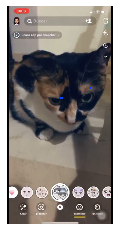

test3.jpg


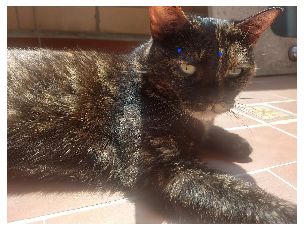

test4.jpg


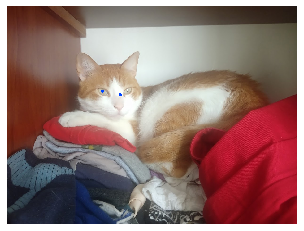

test6.jpg


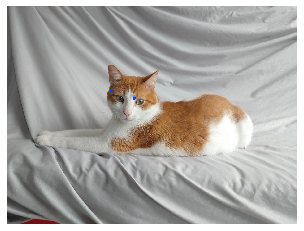

test7.jpg


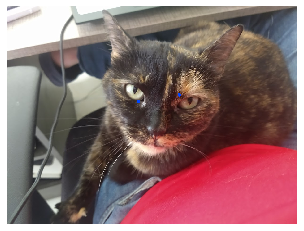

In [31]:
# New Cat images totally unknown for the net
%matplotlib inline
best_model = results_6["model"]

paths = ["test2.jpeg", "test3.jpg", "test4.jpg", "test6.jpg", "test7.jpg"]
index = 1
for path in paths:
    print(path)
    img = cv2.imread(path)
    img_resized = cv2.resize(img, (64, 64))
    rsz = cv2.resize(img, (64, 64))
    testing = rsz.reshape((1, 64, 64, 3))
    
    coordinates = best_model.predict(testing)
    left_eye = (int(coordinates[0][0]), int(coordinates[0][1]))
    right_eye = (int(coordinates[0][2]), int(coordinates[0][3]))
    
    output = img.copy()
    predicted_left_eye = tools.get_resized_eye_point_position(img_resized, output, left_eye)
    predicted_right_eye = tools.get_resized_eye_point_position(img_resized, output, right_eye)
    predicted = tools.add_eyes(output, predicted_left_eye, predicted_right_eye, radius=7, color=(255,69,0))
    cv2.imwrite(f"results/unknown-{index}.jpg", predicted)
    
    image_rgb = cv2.cvtColor(predicted, cv2.COLOR_BGR2RGB)
    plt.axis('off')
    plt.imshow(image_rgb)
    plt.show()
    
    index += 1

## Análisis de iteración

El módelo de MobileNet da un resultado aceptable para imágenes que no conocía, sin embargo, en varios casos la red no es capaz de reconocer correctamente los ojos. Como trabajo a futuro y mejora se sugiere:

- Entrenar una red mucho más profunda que permita extraer más características de entrenamiento
- Probar más arquitecturas de redes disponibles en Keras, para compara resultados con los datos de entrenamiento disponibles.
- Validar por que el data augmentation empeora resultados, debería ser al revés. Probablemente falla por que no estamos extrapolando correctamente los puntos de entrenamiento durante la modificación artificial de las imágenes

In [45]:
history = results_6["history"]
import pickle

with open("train_history/best_model", "wb") as f:
    pickle.dump(history.history, f)

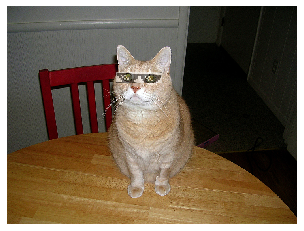

In [49]:
# Function to add glasses
import tools
import numpy as np
import cv2
import random
import glob
from math import atan2, degrees

def angle_between(p1, p2): 
  xDiff = p2[0] - p1[0] 
  yDiff = p2[1] - p1[1] 
  return degrees(atan2(yDiff, xDiff))

def add_glasses(img, left_eye, right_eye):
    glasses_center = np.mean([left_eye, right_eye], axis=0) 
    glasses_size = np.linalg.norm(np.array(left_eye) - np.array(right_eye)) * 2

    angle = -angle_between(left_eye, right_eye)
    glasses = cv2.imread('images/glasses.png', cv2.IMREAD_UNCHANGED)
    overlay_size=(int(glasses_size), int(glasses.shape[0] * glasses_size / glasses.shape[1])) 
    M = cv2.getRotationMatrix2D((glasses.shape[1] / 2, glasses.shape[0] / 2), angle, 1) 
    rotated_glasses = cv2.warpAffine(glasses, M, (glasses.shape[1],glasses.shape[0]))
    res_glasses = cv2.resize(rotated_glasses.copy(), overlay_size)

    bg_img = img.copy()
    x, y = glasses_center[0], glasses_center[1]
    h, w, _ = res_glasses.shape
    roi = bg_img[int(y-h/2):int(y+h/2), int(x-w/2):int(x+w/2)] 

    bg_img[int(y-h/2):int(y+h/2), int(x-w/2):int(x+w/2)] = cv2.addWeighted(roi, 0.5, res_glasses, 0.5, 0)
    
    return bg_img

root_paths =glob.glob("cat-dataset/*", recursive=True)
paths = []
for temp_root_path in root_paths:
    temp_paths = tools.retrieve_img_file_paths(f"{temp_root_path}/")
    for path in temp_paths:
        paths.append(path)

path =  random.choice(paths) 

img = cv2.imread(path) 
true_points = tools.retrieve_face_coordinates(path) 
left_eye = true_points["left-eye"] 
right_eye = true_points["right-eye"] 
bg_img = add_glasses(img, left_eye, right_eye)
image_rgb = cv2.cvtColor(bg_img, cv2.COLOR_BGR2RGB)
plt.axis('off')
plt.imshow(image_rgb)
plt.show()

cat-dataset/CAT_02/00000656_017.jpg
predicted: [[33.170006 26.652687 39.879642 25.06725 ]]
grount truth: (34, 27), (41, 26)


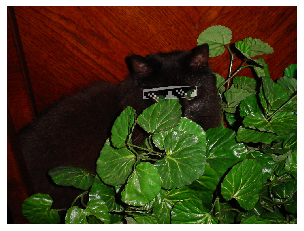

cat-dataset/CAT_05/00001170_012.jpg
predicted: [[28.451038 24.42968  36.349766 23.528393]]
grount truth: (31, 24), (39, 23)


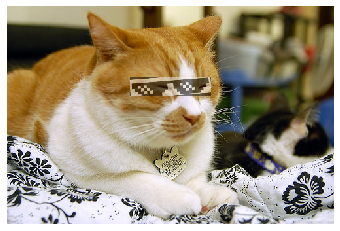

cat-dataset/CAT_05/00001127_003.jpg
predicted: [[16.06986  29.066805 30.050817 26.615099]]
grount truth: (17, 30), (32, 28)


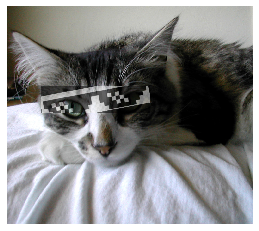

In [51]:
best_model = results_6["model"]

paths = ["cat-dataset/CAT_02/00000656_017.jpg",
         "cat-dataset/CAT_05/00001170_012.jpg",
         "cat-dataset/CAT_05/00001127_003.jpg",]

index = 1

for path in paths:
    print(path)
    img = cv2.imread(path)
    img_resized = cv2.resize(img, (64, 64))
    true_points = tools.retrieve_face_coordinates(path)
    true_left_eye = tools.get_resized_eye_point_position(img, img_resized, true_points["left-eye"])
    true_right_eye = tools.get_resized_eye_point_position(img, img_resized, true_points["right-eye"])
    rsz = cv2.resize(img, (64, 64))
    testing = rsz.reshape((1, 64, 64, 3))
    
    coordinates = best_model.predict(testing)
    print(f"predicted: {coordinates}")
    print(f"grount truth: {true_left_eye}, {true_right_eye}")
    left_eye = (int(coordinates[0][0]), int(coordinates[0][1]))
    right_eye = (int(coordinates[0][2]), int(coordinates[0][3]))
    
    output = img.copy()
    predicted_left_eye = tools.get_resized_eye_point_position(img_resized, output, left_eye)
    predicted_right_eye = tools.get_resized_eye_point_position(img_resized, output, right_eye)
    predicted = add_glasses(output, predicted_left_eye, predicted_right_eye)
    cv2.imwrite(f"results/glasses-validation-{index}.jpg", predicted)
    
    image_rgb = cv2.cvtColor(predicted, cv2.COLOR_BGR2RGB)    
    plt.axis('off')
    plt.imshow(image_rgb)
    plt.show()
    
    index += 1

test2.jpeg


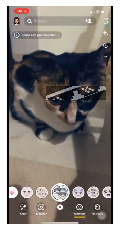

test3.jpg


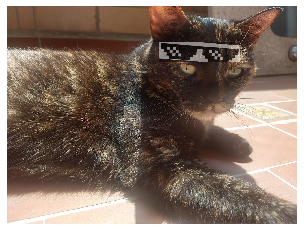

test4.jpg


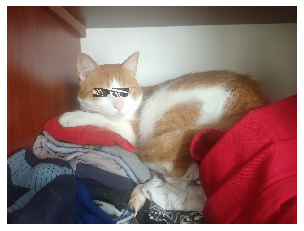

test6.jpg


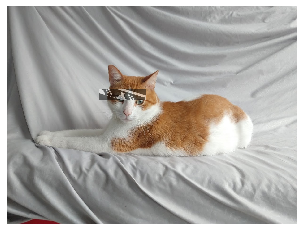

test7.jpg


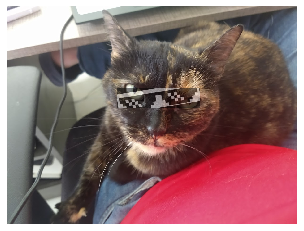

In [52]:
paths = ["test2.jpeg", "test3.jpg", "test4.jpg", "test6.jpg", "test7.jpg"]
index = 1
for path in paths:
    print(path)
    img = cv2.imread(path)
    img_resized = cv2.resize(img, (64, 64))
    rsz = cv2.resize(img, (64, 64))
    testing = rsz.reshape((1, 64, 64, 3))
    
    coordinates = best_model.predict(testing)
    left_eye = (int(coordinates[0][0]), int(coordinates[0][1]))
    right_eye = (int(coordinates[0][2]), int(coordinates[0][3]))
    
    output = img.copy()
    predicted_left_eye = tools.get_resized_eye_point_position(img_resized, output, left_eye)
    predicted_right_eye = tools.get_resized_eye_point_position(img_resized, output, right_eye)
    predicted = add_glasses(output, predicted_left_eye, predicted_right_eye)
    cv2.imwrite(f"results/unknown-{index}.jpg", predicted)
    
    image_rgb = cv2.cvtColor(predicted, cv2.COLOR_BGR2RGB)
    plt.axis('off')
    plt.imshow(image_rgb)
    plt.show()
    
    index += 1